In [1]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import operator
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd
from collections import OrderedDict
from operator import itemgetter

In [2]:
with open("data/entity_dump_cleaned_and_restructured.json", encoding = 'cp1252') as f:
    data = json.load(f)

### Auxiliary functions

In [3]:
def exchange_id_with_value(id):
    value = data[id]
    for index in range(len(data[id])):
        for index_2 in range(len(data[id][index])):
            if type(data[id][index][index_2]) == dict:
                label = data[id][index][index_2]["Label"]
                break


    return label

In [4]:
def extract_artist(work):
    
    artist_id = False
    
    for attribute in work_dict[work+'(work)']:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][0].split("(")[0]
                
    if artist_id:
        artist = exchange_id_with_value(artist_id+"(actor)")
    else:
        artist = 'No artist'
        
    return artist

### Pre-processing

In [5]:
work_dict = {}
for key in list(data.keys()):
    if key.__contains__("work"):
        work_dict[key] = data[key]

In [6]:
actor_dict = {}
for key in list(data.keys()):
    if key.__contains__("actor"):
        actor_dict[key] = data[key]

In [7]:
type_dict = {}
for key in list(data.keys()):
    if key.__contains__("type"):
        type_dict[key] = data[key]

In [8]:
photo_dict = {}
for key in list(data.keys()):
    if key.__contains__("photo"):
        photo_dict[key] = data[key]

In [9]:
### filtering photos with information related to artworks with photographers
photos_filter = {}
for counter, photo in enumerate(photo_dict):
    
    has_work = False
    has_photographer = False
    
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                has_work = True
            if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                has_photographer = True
                    
    if has_work == True and has_photographer == True:
        photos_filter[photo] = photo_dict[photo]

In [10]:
print(f'Number of photos related to an artwork and with a photographer: {len(photos_filter)}')

Number of photos related to an artwork and with a photographer: 30993


In [11]:
# example of the dictionary structure
for idx, (k, v) in enumerate(photos_filter.items()):
    if idx == 1: 
        print((k, v))
        break      

('fln0320501z_p(photo)', [[['53F3EC53-529E-3591-B568-E957F0F8CCAB(-)', 'E54_Dimension(cidoc-crm)'], {'Label': '6x6'}], [['visual_item(07602583%2CT%2C009)', 'E36_Visual_Item(cidoc-crm)'], ['P128i_is_carried_by(cidoc-crm)', '1330%20Artini(negative)']], [['production(fln0320501z_p)', 'E12_Production(cidoc-crm)'], ['P125_used_object_of_type(cidoc-crm)', '194C1FAF-9185-3CF7-AA11-91438B5B5366(type)'], ['P14_carried_out_by(cidoc-crm)', '0832F1B2-0FF5-31AD-AE3B-8D326DE3528D(actor)']], [['fln0320501z_p(photo)', 'E22_Man-Made_Object(cidoc-crm)'], {'Label': 'fln0320501z_p'}, ['P108i_was_produced_by(cidoc-crm)', 'production(fln0320501z_p)'], ['P128_carries(cidoc-crm)', 'visual_item(07602583%2CT%2C009)'], ['P129i_is_subject_of(cidoc-crm)', 'default.jpg(0)'], ['P1_is_identified_by(cidoc-crm)', '7D78206E-0745-3B16-87E7-F83739256C99(appellation)'], ['P24i_changed_ownership_through(cidoc-crm)', 'C5415870-48D6-312F-9EA9-4600283B13B6(acquisition)'], ['P2_has_type(cidoc-crm)', '300046300(aat)'], ['P43_has

### Artwork / photographers / places

In [12]:
### artworks and place where they are
works_and_places = {}
for work in list(work_dict.keys()):
    
    work_as_key = None
    place_id = "No Place"
    
    for attribute in work_dict[work]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "P55_has_current_location(cidoc-crm)":
                work_as_key = work.split("(")[0]
                place_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "P55_has_current_location(cidoc-crm)":
                work_as_key = work.split("(")[0]
                place_id = attribute[index][0].split("(")[0]

    if work_as_key != None:
        works_and_places[work_as_key] = place_id
    
      
    if work_as_key == None:
        work_as_key = work.split("(")[0]
        works_and_places[work_as_key] = "No place"

In [13]:
# example of the dictionary structure
for idx, (k, v) in enumerate(works_and_places.items()):
    if v != 'No place': 
        print((k, v))
        break  

('07602583%2CT%2C002', '946DD00F-13F3-342B-999D-9C5874DC5DE4')


In [14]:
# several information – read carefully
places = defaultdict(list) # list of photographers that have photographed in that place
photographer_count = defaultdict(list) # list of works (repeated) photographed by that photographer
work_photographers = defaultdict(list) # list of photographers that photographed that work
photos_artist = defaultdict(list) # list of works (repeated) of that artist with photos taken
photographed_artworks = [] # list of (repeated) photographed artworks
artist_places = defaultdict(list) # list of places that artist was photographed

work_on_photo = False

for counter, photo in enumerate(photos_filter):
    for attribute in photos_filter[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                work_on_photo = [ element.split("(")[1].replace(")", "") for element in attribute[index] if element.__contains__("visual_item")][0]
            if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                photographer = exchange_id_with_value([element for element in attribute[index] if element.__contains__("actor")][0])
    
    if work_on_photo:
        
        try:
        
            work_place = works_and_places[work_on_photo]
            artist = extract_artist(work_on_photo)

            # place
            if work_place != 'No place':
                work_place = exchange_id_with_value(work_place + "(place)")
                places[work_place].append(photographer)
                artist_places[artist].append(work_place)


            photographer_count[photographer].append(work_on_photo)
            work_photographers[work_on_photo].append(photographer)
            photos_artist[artist].append(work_on_photo)
            photographed_artworks.append(work_on_photo)
            
        except:
            continue

In [15]:
print(len(places))

1517


In [278]:
top_places = {k:len(v) for k,v in places.items()}
top_places = Counter(top_places)
print(top_places)

Counter({'Florenz': 2160, 'Siena': 552, 'Venedig': 297, 'Montepulciano': 257, 'MonteSanSavino': 234, 'SanFrancesco': 197, "CollediVald'Elsa": 194, 'Duomo&SantaMariadelFiore': 184, 'Sovicille': 166, 'PalazzoPitti': 152, 'Genua': 146, 'Perugia': 143, 'SantaMariaAssunta': 141, 'Assisi': 130, "Sant'Agostino": 122, 'SovanadiSorano': 112, 'PalazzoDellaGherardesca': 102, 'Sansepolcro': 101, 'SanDomenico': 101, 'Volterra': 90, 'FoianodellaChiana': 88, 'Cortona': 84, 'GiardinodiBoboli': 79, 'Gubbio': 76, 'Pisa': 76, 'GualdoTadino': 74, 'SanLorenzo': 74, 'Sarteano': 73, 'Lucignano(Arezzo)': 71, 'Monteriggioni': 67, 'Ferrara': 65, 'Chiusi': 64, 'SantissimaAnnunziata': 60, 'Prato': 56, 'SantaMargherita': 56, 'CappellaBarbadori': 54, 'VilladelPoggioImperiale': 52, 'Südwand': 51, 'SanPancrazio': 50, 'Fabriano': 49, 'LarderellodiPomarance': 48, 'Pitigliano': 47, 'SantaCroce': 46, 'TorritadiSiena': 45, 'Taggia': 43, 'Pistoia': 43, 'SanGiovanniEvangelista': 42, 'Nordwand': 41, "SanQuiricod'Orcia": 41, 

In [279]:
top_places_cut = [k for k,v in top_places.most_common(20)]
print(top_places_cut)
print(top_places['Florenz'])

['Florenz', 'Siena', 'Venedig', 'Montepulciano', 'MonteSanSavino', 'SanFrancesco', "CollediVald'Elsa", 'Duomo&SantaMariadelFiore', 'Sovicille', 'PalazzoPitti', 'Genua', 'Perugia', 'SantaMariaAssunta', 'Assisi', "Sant'Agostino", 'SovanadiSorano', 'PalazzoDellaGherardesca', 'Sansepolcro', 'SanDomenico', 'Volterra']
2160


In [280]:
top_photographers = Counter(photographers_count)

In [281]:
print(top_photographers)

Counter({'Sigismondi,Roberto': 5512, 'Artini,Luigi': 2740, 'Bacherini,Paolo': 1407, 'Bazzechi,Ivo': 1372, 'Fiorucci,Carlo': 736, 'Visconti,FrancescoArese': 533, 'Polesel,Mario': 526, 'Laurati,Giorgio': 466, 'Lotz-Bauer,Hilde': 255, 'Schmidt,HansWerner': 224, 'Scheidt,Thomas/Stein,Christian': 195, 'Rabatti-DomingiePhotography': 184, 'Hautmann,Anton': 120, 'Lensini,Andrea': 109, 'DeGiovanni,AndreaGaspare': 92, 'Brogi': 81, 'Trachtenberg,Marvin': 56, 'Schleicher,Barbara': 50, 'Leotta,Marcello': 46, 'Braune,Michael': 45, 'Moscioni,Romualdo': 25, 'Hubacher,Walter': 19, 'Anderson': 18, 'Alinari': 14, 'Lensini,Fabio': 12, 'Quattrone,Antonio': 12, 'Virdis,Davide': 9, 'Tatge,George': 9, 'Scholz,G.': 9, 'Fancelli,StefanonachhistorischerVorlage': 8, 'Lehmann-Brockhaus,Otto': 6, 'Lieberman,Ralph': 6, 'Horn,Walter': 5, 'Sommer,Giorgio': 5, 'BencinieSansoni': 5, 'Ciganovic,Josip': 4, 'Tronci,Massimiliano': 3, 'Horn,WalternachhistorischerVorlage': 3, 'Brillet-Buyet,Luigi': 3, 'Deckers-Matzko,R.J.': 2

In [282]:
top7_photographers = ['Sigismondi,Roberto','Artini,Luigi','Bacherini,Paolo','Bazzechi,Ivo',
                      'Fiorucci,Carlo','Visconti,FrancescoArese','Polesel,Mario','Others']

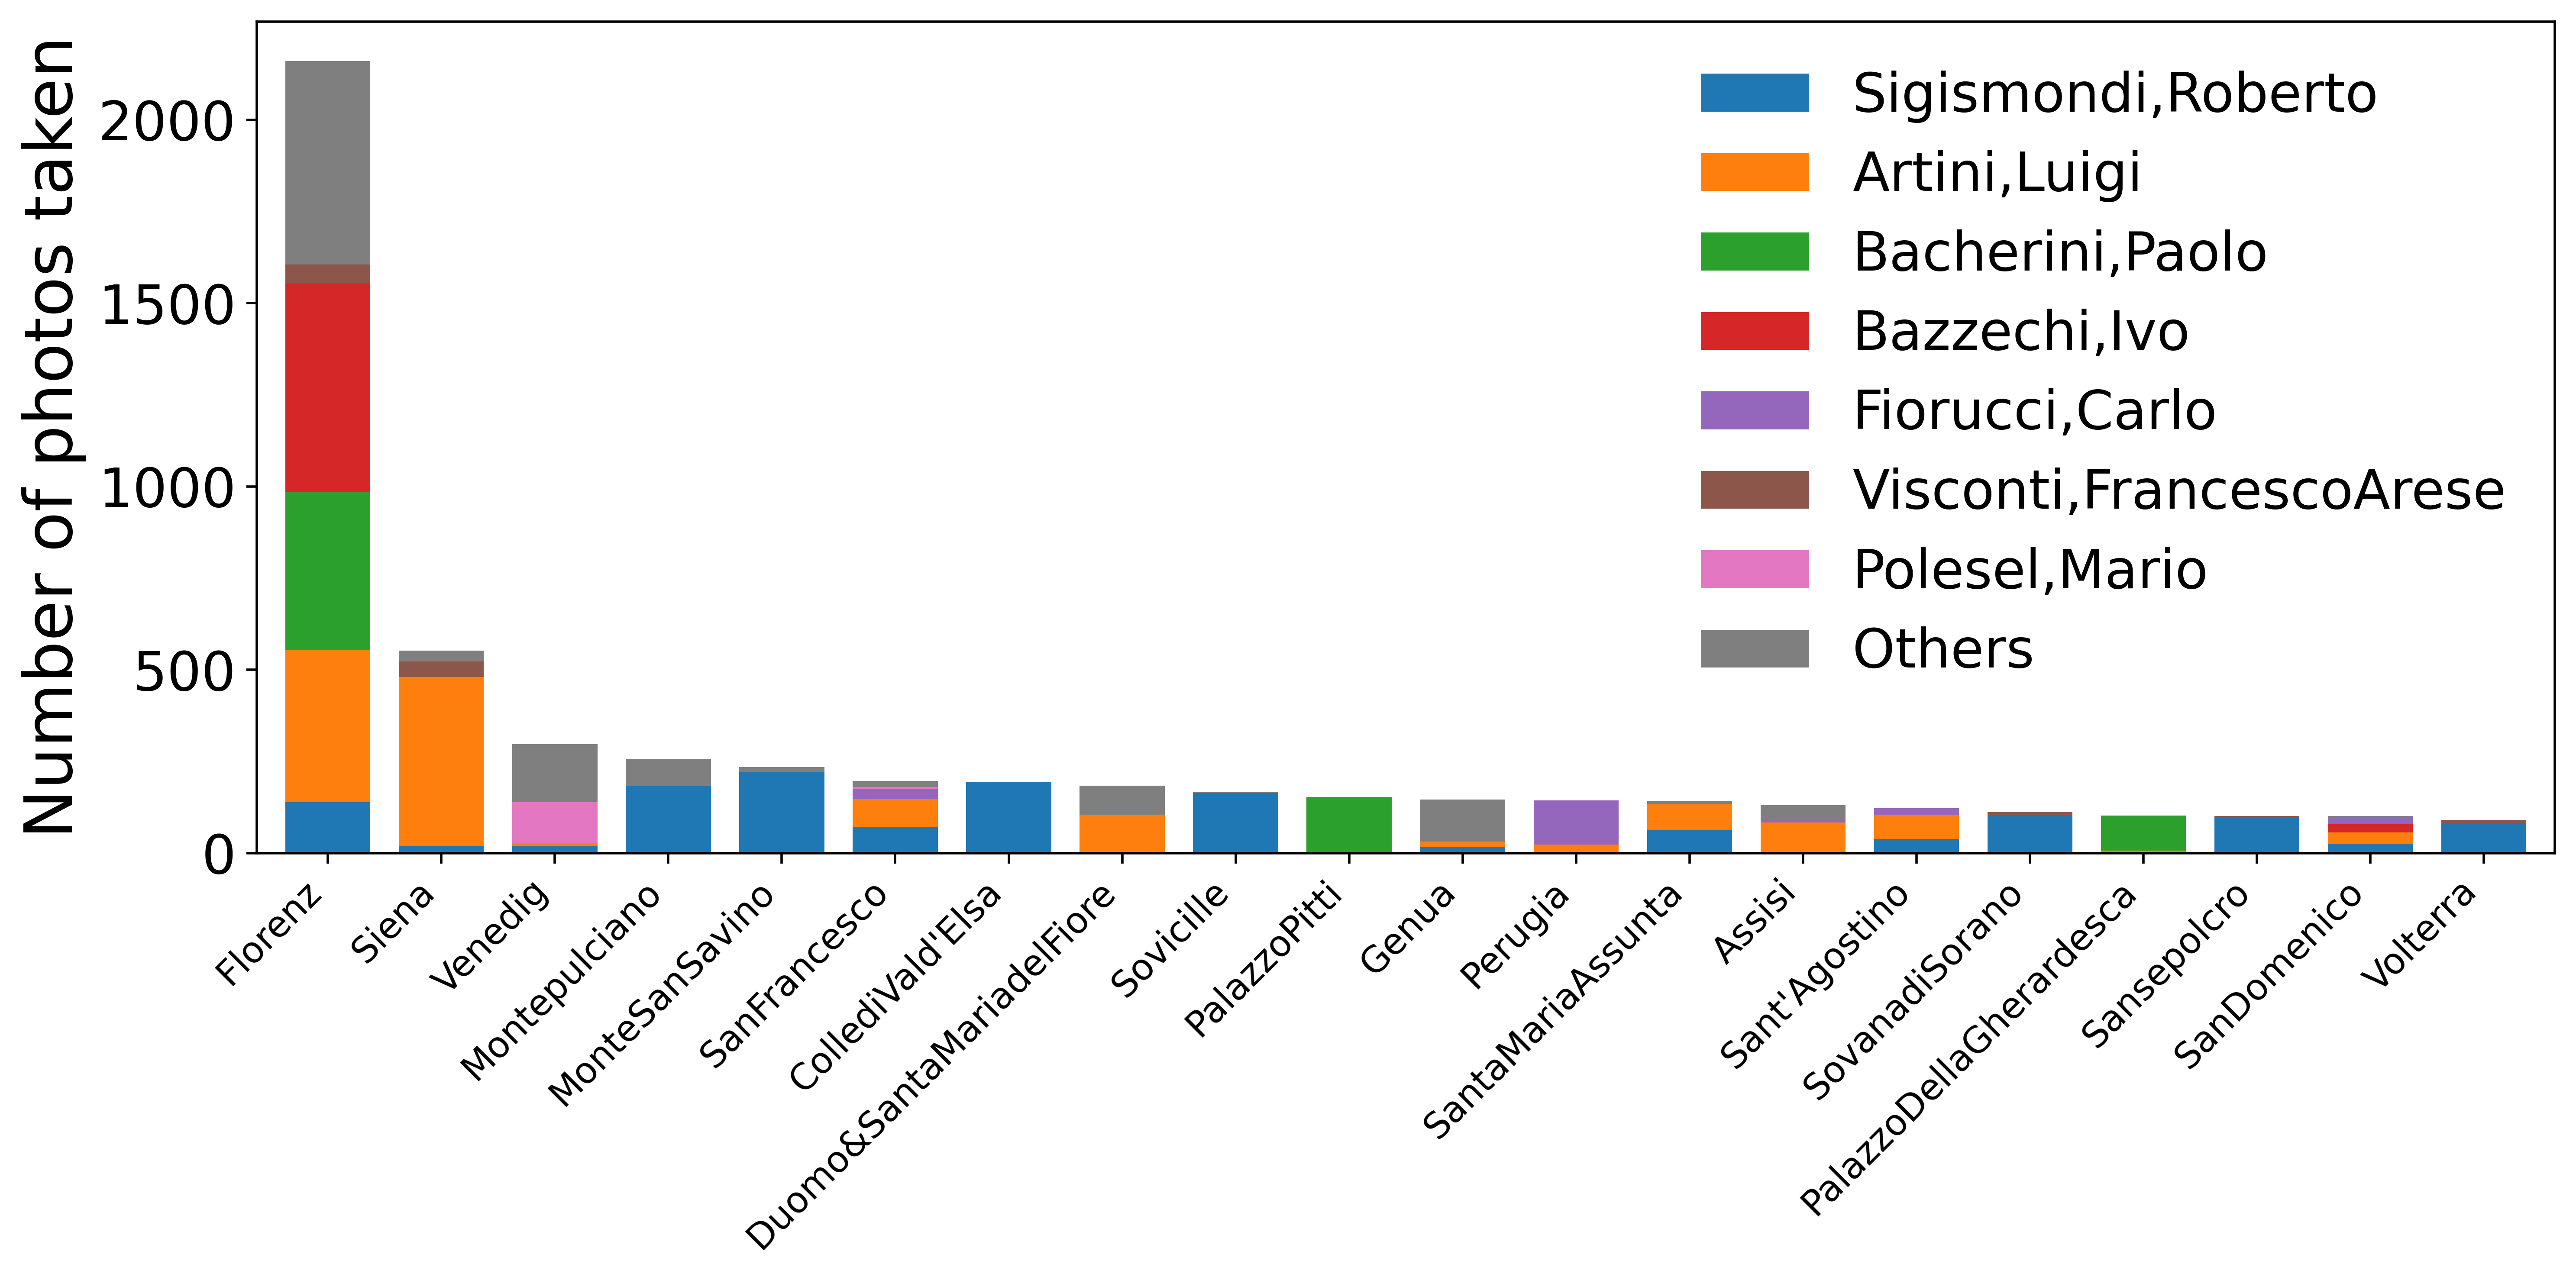

In [283]:
# plotting artworks per place per top artists
# figure environment
fig, ax = plt.subplots(figsize=(12,6), dpi=500)

# preparing data
labels = top_places_cut

photograpers_values = defaultdict(list)
for p in top7_photographers:
    photograpers_values[p] = np.array([places[place].count(p) for place in top_places_cut])

sum_top7 = np.sum(np.array(list(photograpers_values.values()), dtype=int), axis=0)

others = np.array([top_places[place] - sum_top7[i] for i,place in enumerate(top_places_cut)])

photograpers_values['Others'] = others

df = pd.DataFrame.from_dict(photograpers_values)
df.index = top_places_cut

width = 0.75

# plotting
df.plot(kind="bar",stacked=True,ax=ax,width=width)


# axis set-up
#ax.set_xlabel('Number of artists', fontsize=14)
ax.set_ylabel('Number of photos taken', fontsize=22)
ax.set_xticks(list(range(len(labels))),labels,rotation=45, ha='right',fontsize=12)

# set axis format
ax.tick_params(axis='y', which='major', labelsize=18)

#Set legend
ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=18)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/photos_place_topphotographers.png', format='png', dpi=500)
plt.savefig(f'figures/photos_place_topphotographers.pdf', format='pdf', dpi=500)

plt.show()

### Artworks / photographers

In [28]:
# dictionary with phothograpers as key and lists of size two as elements
# element 1 is total of photos, element 2 is number of unique artworks photographed by photographer
photographers_artworks = defaultdict(list)

for k,v in photographer_count.items():
    photographers_artworks[k] = [len(v), len(set(v))]
    
photographers_artworks = sorted(photographers_artworks.items(),  key=lambda t: t[1][0], reverse=True)
photographers_artworks = OrderedDict(photographers_artworks)

In [29]:
print(photographers_artworks)

OrderedDict([('Sigismondi,Roberto', [7820, 3359]), ('Artini,Luigi', [5451, 2410]), ('Bacherini,Paolo', [2963, 1208]), ('Bazzechi,Ivo', [2452, 1141]), ('Fiorucci,Carlo', [1532, 1131]), ('Laurati,Giorgio', [1388, 446]), ('Sansoni,Guido', [1156, 972]), ('Polesel,Mario', [1055, 247]), ('Scheidt,Thomas/Stein,Christian', [760, 252]), ('DeGiovanni,AndreaGaspare', [633, 107]), ('Lotz-Bauer,Hilde', [624, 383]), ('Visconti,FrancescoArese', [536, 114]), ('Rabatti-DomingiePhotography', [319, 310]), ('Schmidt,HansWerner', [247, 81]), ('Hautmann,Anton', [231, 53]), ('Lensini,Andrea', [109, 31]), ('Schleicher,Barbara', [107, 7]), ('Brogi', [90, 65]), ('Trachtenberg,Marvin', [61, 30]), ('Braune,Michael', [57, 28]), ('Leotta,Marcello', [46, 3]), ('Kriegbaum,Friedrich', [26, 3]), ('Moscioni,Romualdo', [25, 17]), ('Lieberman,Ralph', [25, 16]), ('Alinari', [19, 14]), ('Hubacher,Walter', [19, 17]), ('Anderson', [18, 16]), ('Lensini,Fabio', [17, 9]), ('Quattrone,Antonio', [17, 10]), ('Fancelli,Stefanonachhi

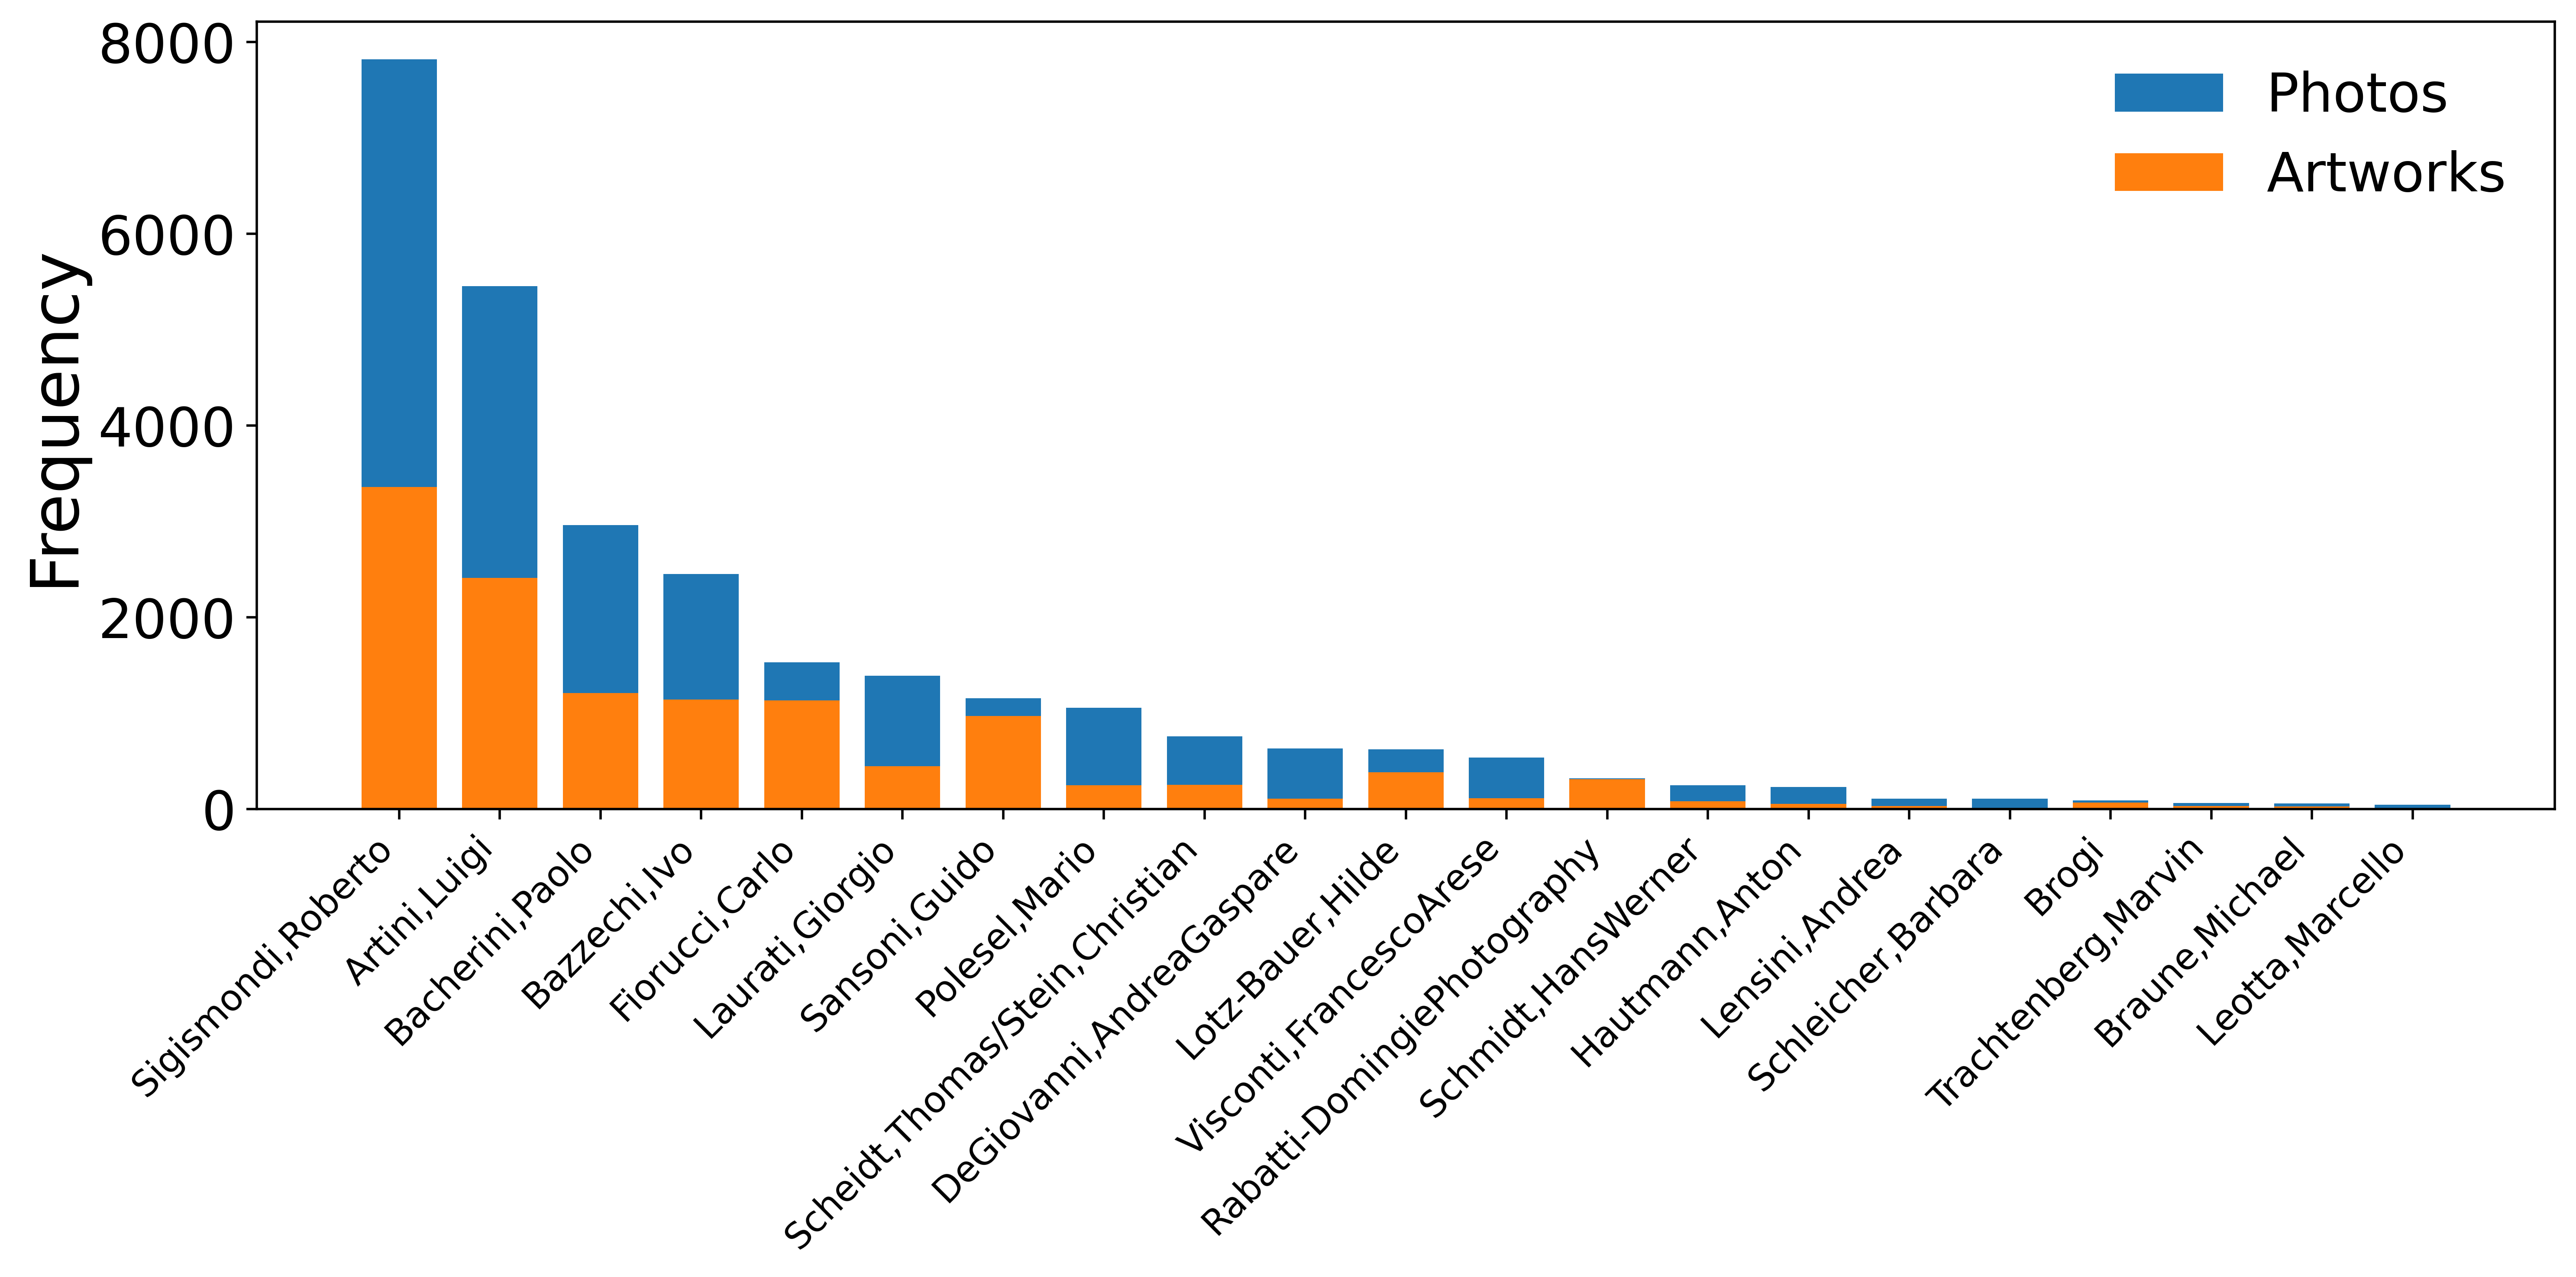

In [286]:
# plotting total photos / artworks per top artists
# figure environment
fig, ax = plt.subplots(figsize=(12,6), dpi=500)

# preparing data
labels = []
Y1 = []
Y2 = []

for idx, (k,v) in enumerate(photographers_artworks.items()):
    labels.append(k)
    Y1.append(v[0])
    Y2.append(v[1])
    if idx == 20:
        break

width = 0.75

# plotting
ax.bar(labels, Y1, width=width, label='Photos')
ax.bar(labels, Y2, width=width, label='Artworks')


# axis set-up
#ax.set_xlabel('Number of artists', fontsize=14)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xticks(list(range(len(labels))),labels,rotation=45, ha='right',fontsize=12)
#ax.set_yscale('log')

# set axis format
ax.tick_params(axis='y', which='major', labelsize=18)

#Set legend
ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=18)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/photos_artworks_topphotographers.png', format='png', dpi=500)
plt.savefig(f'figures/photos_artworks_topphotographers.pdf', format='pdf', dpi=500)

plt.show()

In [287]:
print(photographers_artworks)

OrderedDict([('Sigismondi,Roberto', [7820, 3359]), ('Artini,Luigi', [5451, 2410]), ('Bacherini,Paolo', [2963, 1208]), ('Bazzechi,Ivo', [2452, 1141]), ('Fiorucci,Carlo', [1532, 1131]), ('Laurati,Giorgio', [1388, 446]), ('Sansoni,Guido', [1156, 972]), ('Polesel,Mario', [1055, 247]), ('Scheidt,Thomas/Stein,Christian', [760, 252]), ('DeGiovanni,AndreaGaspare', [633, 107]), ('Lotz-Bauer,Hilde', [624, 383]), ('Visconti,FrancescoArese', [536, 114]), ('Rabatti-DomingiePhotography', [319, 310]), ('Schmidt,HansWerner', [247, 81]), ('Hautmann,Anton', [231, 53]), ('Lensini,Andrea', [109, 31]), ('Schleicher,Barbara', [107, 7]), ('Brogi', [90, 65]), ('Trachtenberg,Marvin', [61, 30]), ('Braune,Michael', [57, 28]), ('Leotta,Marcello', [46, 3]), ('Kriegbaum,Friedrich', [26, 3]), ('Moscioni,Romualdo', [25, 17]), ('Lieberman,Ralph', [25, 16]), ('Alinari', [19, 14]), ('Hubacher,Walter', [19, 17]), ('Anderson', [18, 16]), ('Lensini,Fabio', [17, 9]), ('Quattrone,Antonio', [17, 10]), ('Fancelli,Stefanonachhi

### Photographer / artwork / artist network filtering

In [288]:
# filtering only works that were photographed by at least 2 photographers
popular_works = []
for k,v in work_photographers.items():
    if len(set(v)) > 2:
        popular_works.append(k)

In [289]:
print(len(popular_works))

39


In [290]:
# creating the network
G = nx.Graph()

artist_id = None

for work in popular_works:
    
    for attribute in work_dict[work+'(work)']:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][0].split("(")[0]
                
    if artist_id == None:
        continue
    else:
        G.add_node(work, ent='artwork')
        artist = exchange_id_with_value(artist_id+"(actor)")
        G.add_node(artist, ent='artist')
        G.add_edge(work, artist, weight=1)
    
        for photographer in work_photographers[work]:
            G.add_node(photographer, ent='photographer')
            G.add_edge(work, photographer, weight=work_photographers[work].count(photographer))

In [291]:
# node sets
artworks = {n for n, d in G.nodes(data=True) if d["ent"] == 'artwork'}
artists = {n for n, d in G.nodes(data=True) if d["ent"] == 'artist'}
photographers = {n for n, d in G.nodes(data=True) if d["ent"] == 'photographer'}

In [292]:
print(len(artworks))
print(len(artists))
print(len(photographers))

33
14
18


In [293]:
print(len(G.nodes()))

65


In [294]:
### saving the network filtered by: artworks with artists, artwork with at least two photographers
nx.write_gexf(G,'networks/artist_artwork_photographer_filtered.gexf')

### Photos of artworks by artists

In [298]:
del photos_artist['No artist']

In [304]:
popular_artists = defaultdict(list)

for k,v in photos_artist.items():
    popular_artists[k] = [len(v), len(set(v))]
    
popular_artists = sorted(popular_artists.items(),  key=lambda t: t[1][1], reverse=True)
popular_artists = OrderedDict(popular_artists)

In [305]:
print(popular_artists)

OrderedDict([('Bazzoli,Giuseppe', [224, 216]), ('Franchi,Alessandro', [135, 135]), ('Marinelli,Gaetano', [90, 90]), ('LuigiMussini', [69, 68]), ('Vasari,Giorgio', [135, 65]), ('Pisano,Andrea', [105, 49]), ('Bernardinodellegrottesche', [51, 32]), ('PietrodiGiovanni(1386)', [108, 30]), ('Dosio,Giovanantonio', [27, 26]), ('Bandinelli,Bartolomeo', [33, 24]), ('Perugino,PietrodiCristoforoVannucci', [87, 22]), ('Rosselli,Matteo', [26, 21]), ('MichelangeloBuonarroti', [111, 20]), ('Gaggini,Domenico', [27, 19]), ('Delfin,CharlesClaude', [20, 19]), ('Cinganelli,Michelangelo', [50, 18]), ('Montorsoli,GiovanniAngelo', [22, 18]), ('ArnolfodiCambio', [52, 18]), ('Margotta,il', [20, 18]), ('Robbia,Andreadella', [59, 17]), ('Ammannati,BartolomeodiAntonio', [23, 16]), ('Lippi,Filippino', [41, 16]), ('ZweiterMiniaturmalerPerugias', [15, 15]), ('MatteodaGualdo', [50, 15]), ('Michelucci,Giovanni', [201, 15]), ('Orgagna', [34, 15]), ('Ciceri,GiovanniBattista', [43, 14]), ('Foggini,GiovanniBattista', [24, 

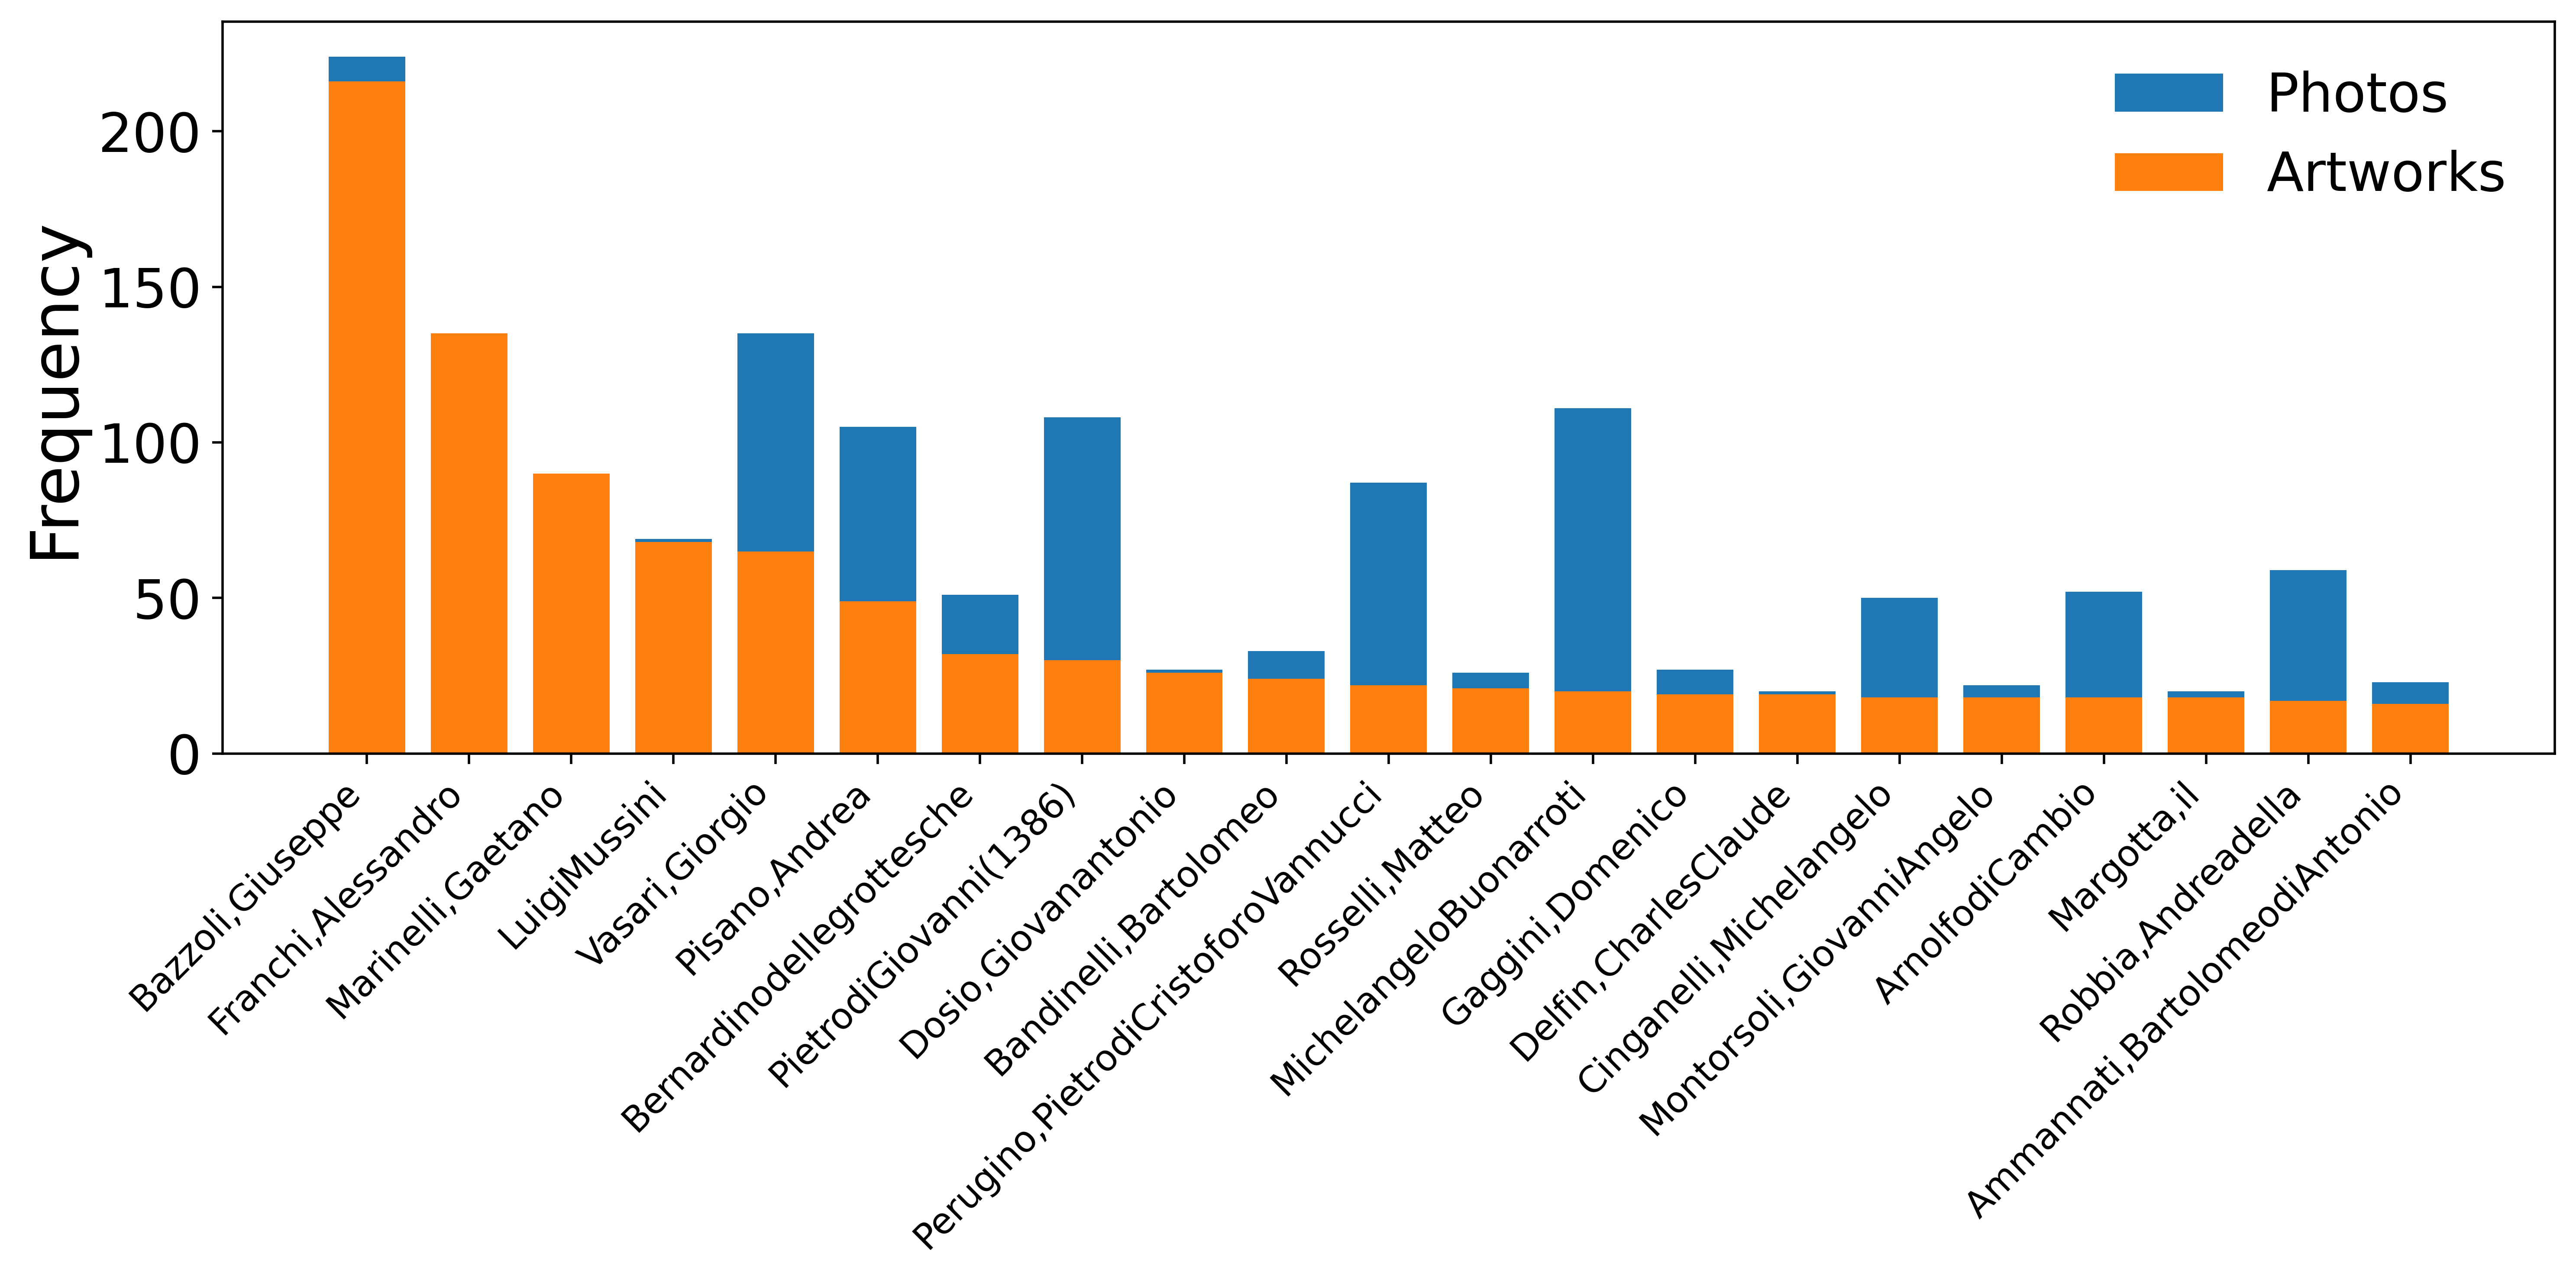

In [306]:
# plotting total photos / artworks per top artists
# figure environment
fig, ax = plt.subplots(figsize=(12,6), dpi=500)

# preparing data
labels = []
Y1 = []
Y2 = []

for idx, (k,v) in enumerate(popular_artists.items()):
    labels.append(k)
    Y1.append(v[0])
    Y2.append(v[1])
    if idx == 20:
        break

width = 0.75

# plotting
ax.bar(labels, Y1, width=width, label='Photos')
ax.bar(labels, Y2, width=width, label='Artworks')


# axis set-up
#ax.set_xlabel('Number of artists', fontsize=14)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xticks(list(range(len(labels))),labels,rotation=45, ha='right',fontsize=12)
#ax.set_yscale('log')

# set axis format
ax.tick_params(axis='y', which='major', labelsize=18)

#Set legend
ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=18)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/photos_artworks_topartists.png', format='png', dpi=500)
plt.savefig(f'figures/photos_artworks_topartists.pdf', format='pdf', dpi=500)

plt.show()

### Artists and places

In [22]:
print(len(artist_places))
del artist_places['No artist']
print(len(artist_places))

910
909


In [27]:
place_qty = defaultdict(dict)

for k,v in artist_places.items():
    place_qty[k] = Counter(v)

In [28]:
print(place_qty)

defaultdict(<class 'dict'>, {'FiorenzodiLorenzo': Counter({'SantaMariaNuova': 9, 'Deruta': 5, 'Perugia': 2, 'ChiesadellaMadonnadellaVilla': 1}), 'Nelli,OttavianodiMartino': Counter({'Gubbio': 15, 'SantaMariaNuova': 8, "Sant'Agostino": 1, 'Perugia': 1}), 'CennidiPepo': Counter({'Assisi': 23, 'SanFrancesco': 8, 'SantaTrìnita': 1}), 'Obriachi': Counter({'Chiusi': 11}), 'Bourdon': Counter({"Sant'Agostino": 1}), 'LorenzoMarrina': Counter({"Sant'Agostino": 5, 'Collegiata&SanLorenzo&SantiLorenzoeApollinare': 3}), 'Rosi,Alessandro': Counter({'BagnoaRipoli': 1, 'BadiadiPassignano': 1, 'CapallediCampiBisenzio': 1}), 'Brueghel,Pieter(derJüngere)': Counter({'CastelnuovoMagra': 3}), 'Canova,Antonio': Counter({'SantaCroce': 2}), 'GiovanniBattistaCaccini': Counter({'Florenz': 4, 'SantiApostoli': 3, 'GiardinodiBoboli': 1, "Sant'Agostino": 1}), 'Pucciarelli,BartolomeodiTommaso': Counter({'SantaMariadiTurrita': 5, 'Rasiglia': 4, 'CappellaParadisi': 3, 'SanFrancesco': 2, 'Foligno': 2}), 'Robbia,Andreadel

In [30]:
G = nx.Graph()

for k,v in place_qty.items():
    
    G.add_node(k, ent='artist')
    
    for k2,v2 in v.items():
        
        G.add_node(k2, ent='place')
        G.add_edge(k, k2, weight=v2)

In [31]:
# node sets
artists = {n for n, d in G.nodes(data=True) if d["ent"] == 'artist'}
places = {n for n, d in G.nodes(data=True) if d["ent"] == 'place'}

In [33]:
print(len(artists))
print(len(places))

909
727


In [37]:
### deleting artist with less than 05 places
low_artists = [n for n in artists if G.degree(n) < 5]

In [39]:
G.remove_nodes_from(low_artists)

In [40]:
### deleting places with no artists
empty_places = [n for n in places if G.degree(n) == 0]

In [42]:
G.remove_nodes_from(empty_places)

In [43]:
### saving the network filtered by: artists with at least five different places, 
nx.write_gexf(G,'networks/artist_place_filtered.gexf')

## Distributions

### Distribution number of artworks with number of photos 

In [23]:
photoDist = Counter(sorted(photographed_artworks))
#print(photoDist)
photoDist = Counter(sorted(list(photoDist.values())))

X, Y = [], []
for s,f in photoDist.items():
    X.append(s)
    Y.append(f)
    
print(photoDist)
print(X)
print(Y)

Counter({1: 7745, 2: 1669, 3: 860, 4: 585, 5: 303, 6: 280, 7: 175, 8: 131, 9: 69, 10: 69, 11: 42, 12: 31, 14: 25, 15: 22, 13: 18, 16: 16, 17: 9, 22: 8, 20: 7, 23: 7, 25: 7, 27: 7, 18: 6, 19: 6, 21: 6, 24: 5, 28: 4, 32: 4, 36: 3, 48: 3, 26: 2, 29: 2, 30: 2, 33: 2, 39: 2, 40: 2, 31: 1, 34: 1, 37: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 54: 1, 56: 1, 58: 1, 60: 1, 61: 1, 63: 1, 64: 1, 67: 1})
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 48, 54, 56, 58, 60, 61, 63, 64, 67]
[7745, 1669, 860, 585, 303, 280, 175, 131, 69, 69, 42, 31, 18, 25, 22, 16, 9, 6, 6, 7, 6, 8, 7, 5, 7, 2, 7, 4, 2, 2, 1, 4, 2, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]


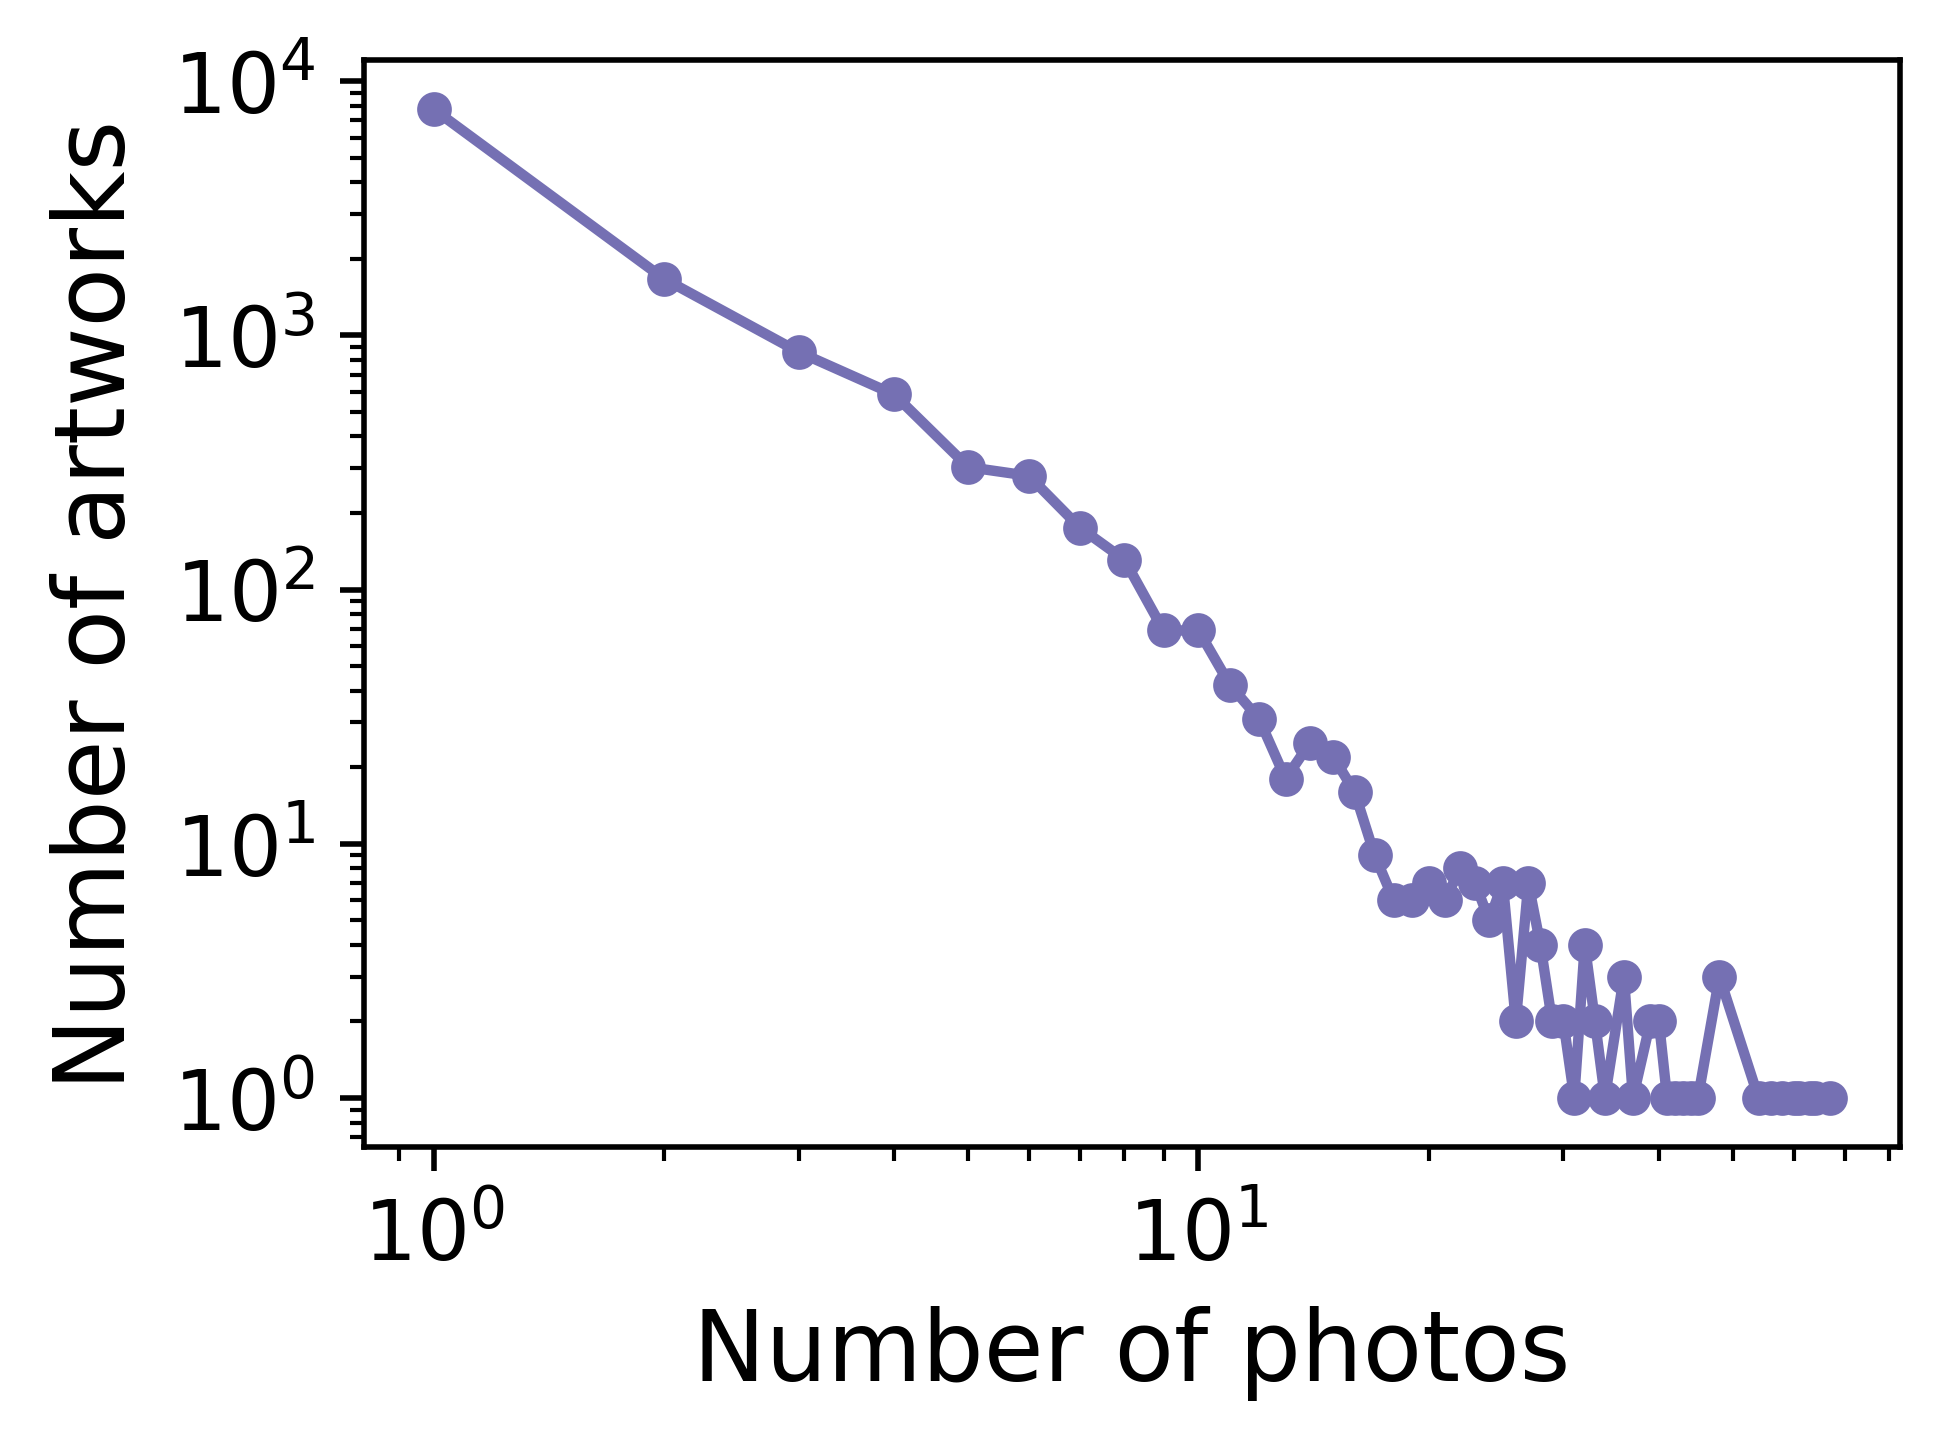

In [25]:
# plotting distributions 
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.loglog(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of photos', fontsize=14)
ax.set_ylabel('Number of artworks', fontsize=14)

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_artwork_photo.png', format='png', dpi=500)
plt.savefig(f'figures/dist_artwork_photo.pdf', format='pdf', dpi=500)

plt.show()

### Distribution number of artists with number of photos 

In [33]:
del photos_artist['No artist']

In [36]:
photoDist = [len(v) for k,v in photos_artist.items()]
photoDist = Counter(sorted(photoDist))
print(photoDist)

X, Y = [], []
for s,f in photoDist.items():
    X.append(s)
    Y.append(f)
    
print(X)
print(Y)

Counter({1: 444, 2: 204, 3: 138, 4: 99, 5: 53, 6: 46, 7: 37, 8: 36, 9: 25, 10: 22, 13: 18, 14: 17, 15: 16, 11: 13, 12: 10, 22: 9, 18: 7, 20: 7, 17: 6, 21: 6, 24: 6, 25: 6, 16: 5, 19: 5, 30: 5, 33: 5, 39: 5, 26: 4, 27: 4, 28: 4, 32: 4, 43: 4, 34: 3, 36: 3, 45: 3, 50: 3, 23: 2, 31: 2, 41: 2, 44: 2, 49: 2, 51: 2, 53: 2, 135: 2, 29: 1, 35: 1, 37: 1, 40: 1, 42: 1, 52: 1, 58: 1, 59: 1, 63: 1, 64: 1, 69: 1, 77: 1, 81: 1, 83: 1, 87: 1, 90: 1, 105: 1, 108: 1, 111: 1, 152: 1, 201: 1, 224: 1})
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 58, 59, 63, 64, 69, 77, 81, 83, 87, 90, 105, 108, 111, 135, 152, 201, 224]
[444, 204, 138, 99, 53, 46, 37, 36, 25, 22, 13, 10, 18, 17, 16, 5, 6, 7, 5, 7, 6, 9, 2, 6, 6, 4, 4, 4, 1, 5, 2, 4, 5, 3, 1, 3, 1, 5, 1, 2, 1, 4, 2, 3, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]


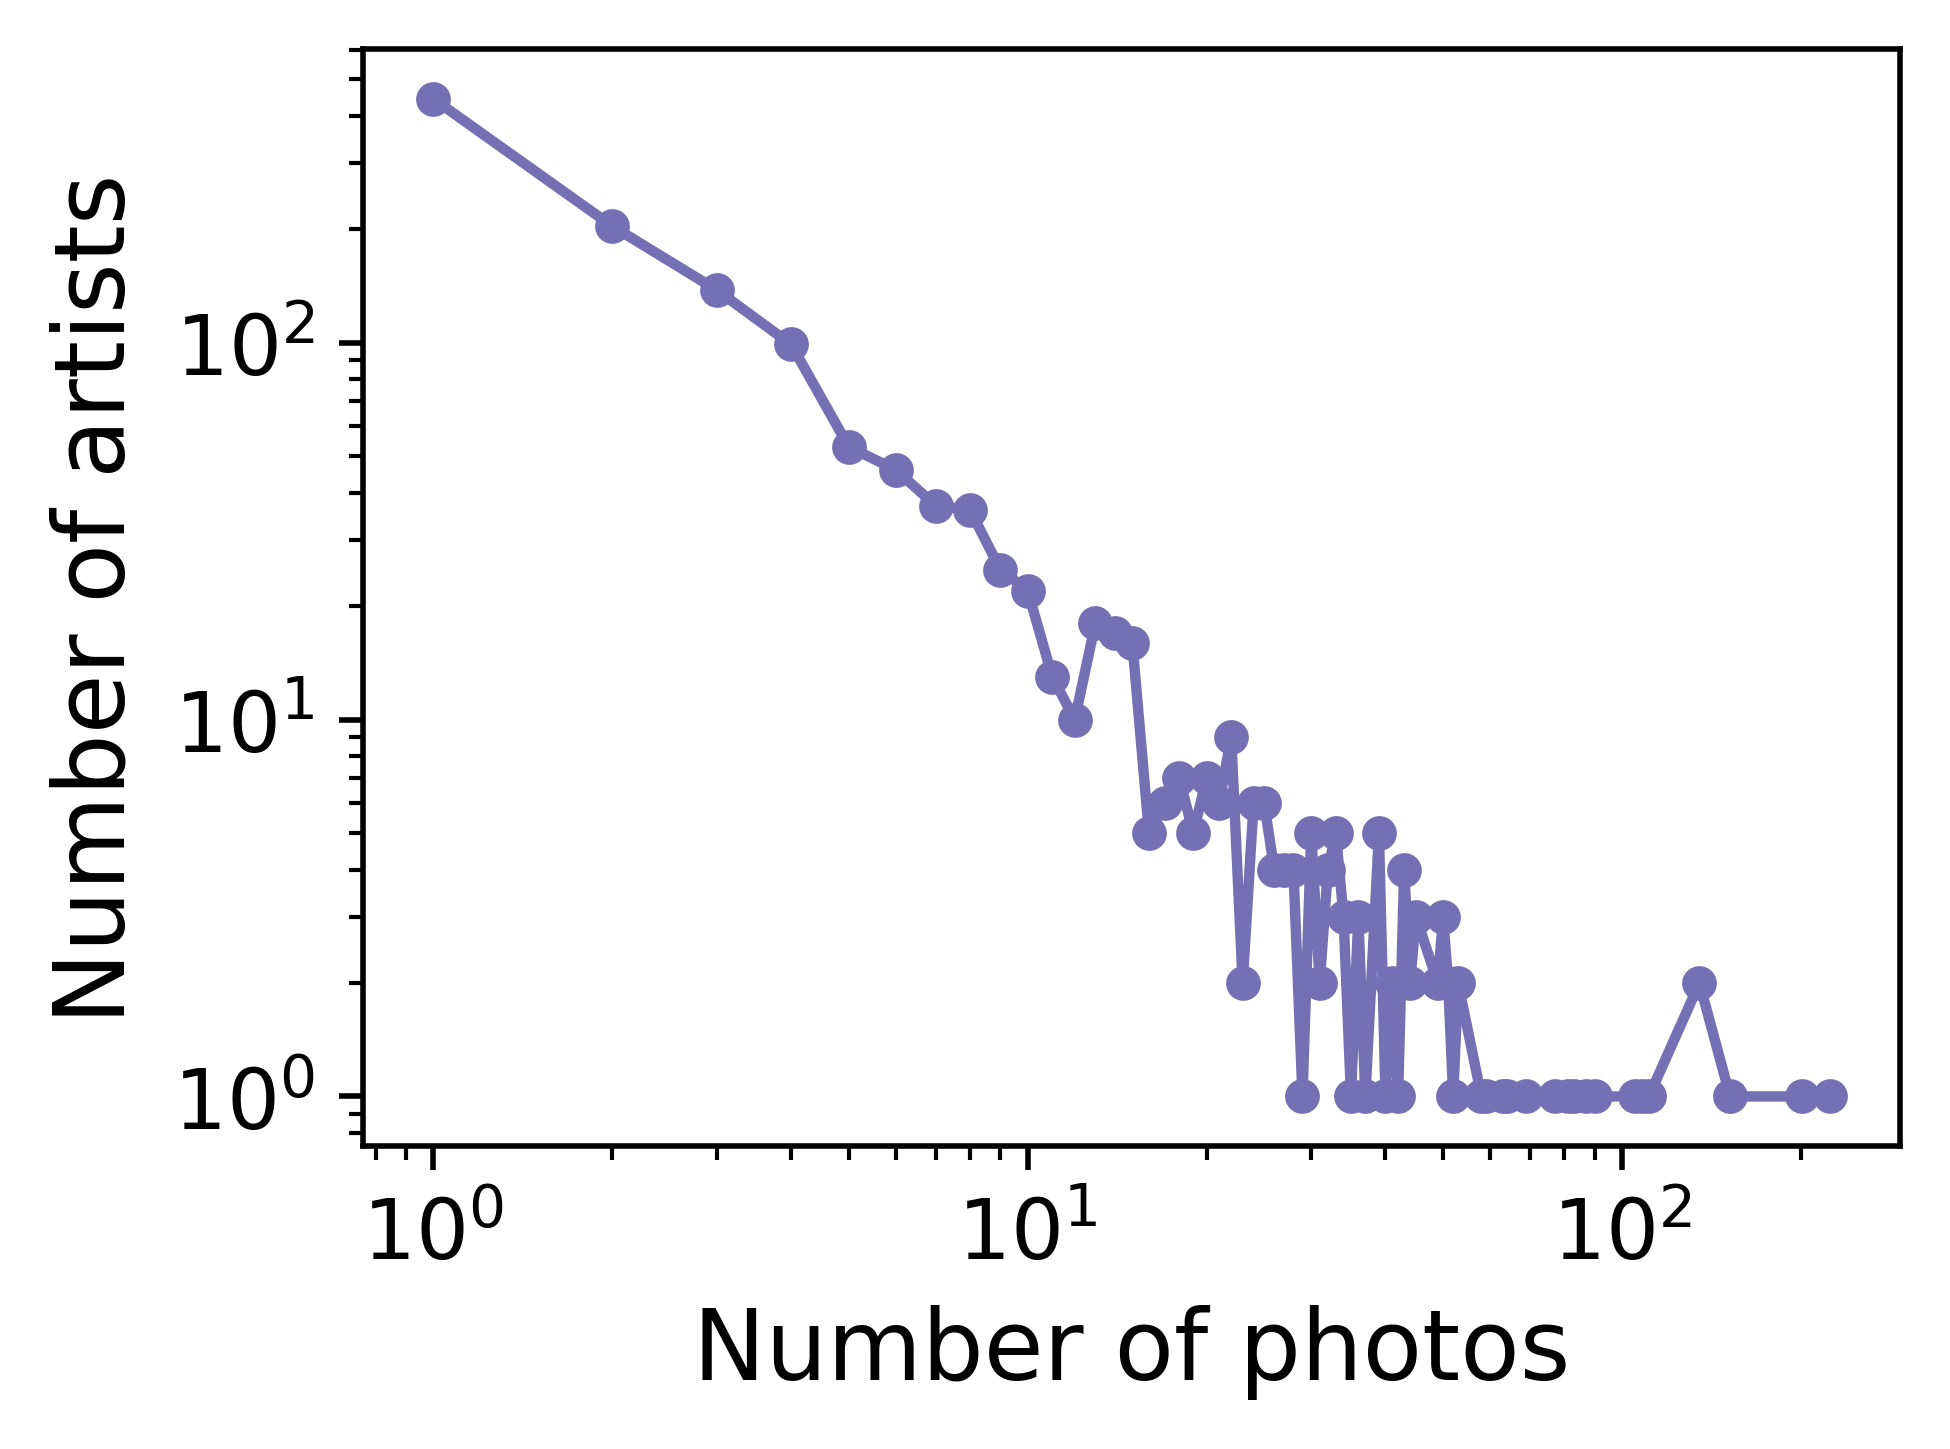

In [37]:
# plotting distributions 
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.loglog(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of photos', fontsize=14)
ax.set_ylabel('Number of artists', fontsize=14)

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_artist_photo.png', format='png', dpi=500)
plt.savefig(f'figures/dist_artist_photo.pdf', format='pdf', dpi=500)

plt.show()

### Distribution number of photographers with number of photos 

In [38]:
photoDist = [len(v) for k,v in photographer_count.items()]
photoDist = Counter(sorted(photoDist))
print(photoDist)

X, Y = [], []
for s,f in photoDist.items():
    X.append(s)
    Y.append(f)
    
print(X)
print(Y)

Counter({1: 9, 2: 8, 3: 6, 9: 4, 5: 3, 4: 2, 17: 2, 19: 2, 25: 2, 6: 1, 8: 1, 15: 1, 18: 1, 26: 1, 46: 1, 57: 1, 61: 1, 90: 1, 107: 1, 109: 1, 231: 1, 247: 1, 319: 1, 536: 1, 624: 1, 633: 1, 760: 1, 1055: 1, 1156: 1, 1388: 1, 1532: 1, 2452: 1, 2963: 1, 5451: 1, 7820: 1})
[1, 2, 3, 4, 5, 6, 8, 9, 15, 17, 18, 19, 25, 26, 46, 57, 61, 90, 107, 109, 231, 247, 319, 536, 624, 633, 760, 1055, 1156, 1388, 1532, 2452, 2963, 5451, 7820]
[9, 8, 6, 2, 3, 1, 1, 4, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


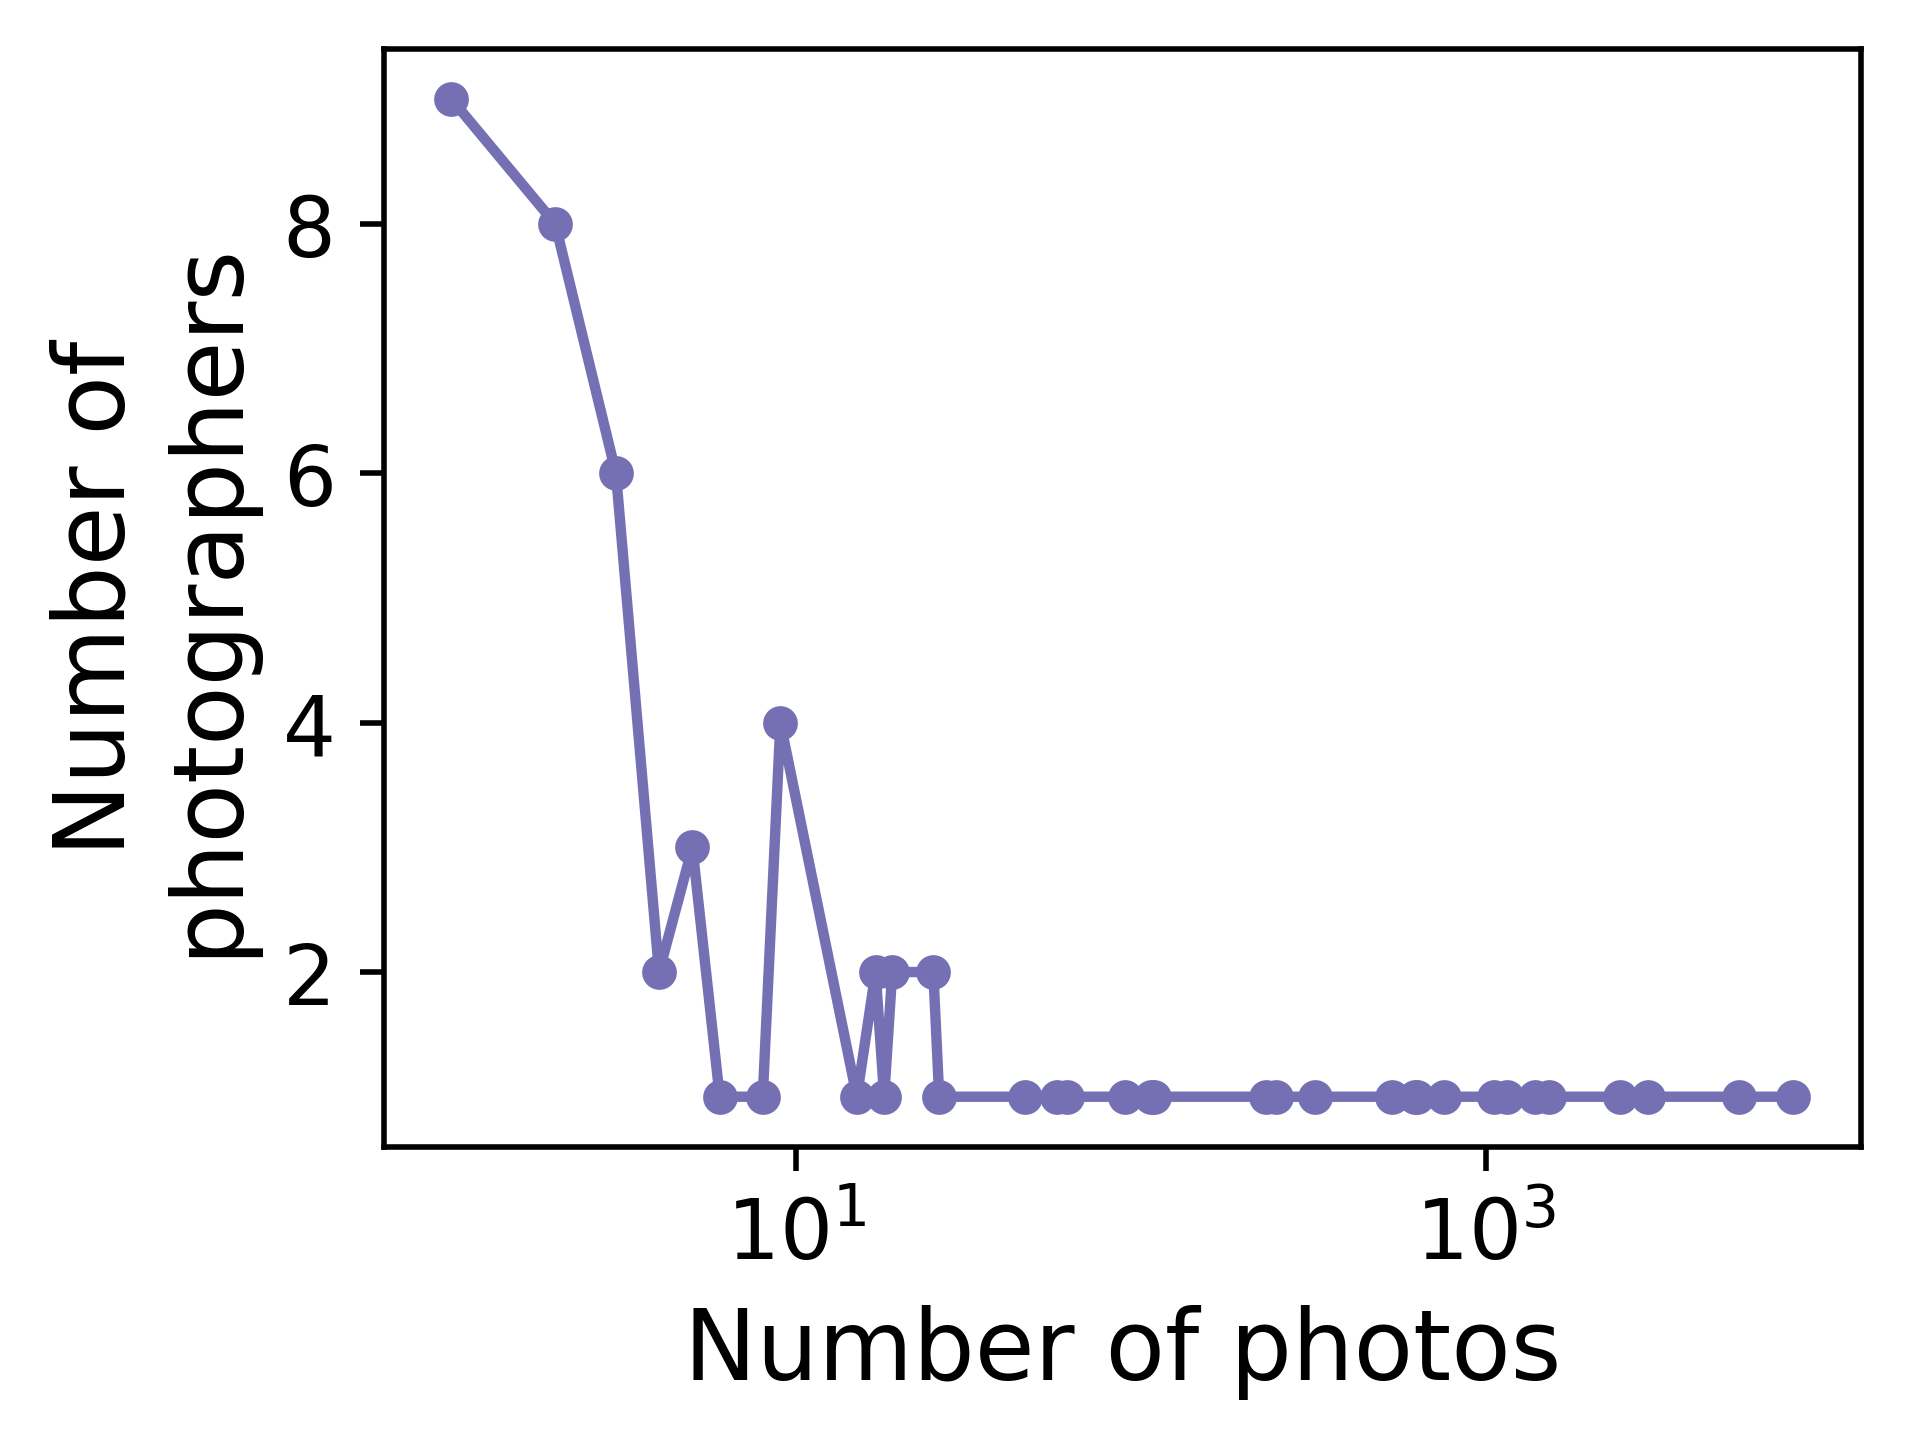

In [43]:
# plotting distributions 
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.plot(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of photos', fontsize=14)
ax.set_ylabel('Number of\nphotographers', fontsize=14)
ax.set_xscale('log')

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_photographer_photo.png', format='png', dpi=500)
plt.savefig(f'figures/dist_photographer_photo.pdf', format='pdf', dpi=500)

plt.show()

### Testing area!

In [93]:
sigrob = [places[place].count('Sigismondi,Roberto') for place in top_places_cut]
print(sigrob)

[139, 18, 18, 184, 221, 72, 194, 0, 164, 2, 17, 0, 62, 0, 38, 103, 0, 95, 25, 78, 88, 84, 26, 61, 0, 69, 9, 73, 63, 67]


In [96]:
photograpers_values = defaultdict(list)
for p in top7_photographers:
    photograpers_values[p] = [places[place].count(p) for place in top_places_cut]

In [97]:
print(photograpers_values)

defaultdict(<class 'list'>, {'Sigismondi,Roberto': [139, 18, 18, 184, 221, 72, 194, 0, 164, 2, 17, 0, 62, 0, 38, 103, 0, 95, 25, 78, 88, 84, 26, 61, 0, 69, 9, 73, 63, 67], 'Artini,Luigi': [415, 462, 8, 0, 0, 75, 0, 104, 0, 0, 14, 23, 72, 83, 66, 0, 6, 0, 31, 0, 0, 0, 1, 0, 6, 0, 25, 0, 7, 0], 'Bacherini,Paolo': [431, 0, 0, 0, 0, 0, 0, 1, 0, 149, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0], 'Bazzechi,Ivo': [569, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 32, 0, 42, 0, 19, 0, 0, 0], 'Fiorucci,Carlo': [0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 120, 1, 7, 18, 0, 0, 0, 16, 0, 0, 0, 0, 15, 0, 5, 3, 0, 0, 0], 'Visconti,FrancescoArese': [51, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 6, 0, 12, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0], 'Polesel,Mario': [0, 0, 113, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0]})


In [103]:
others = [top_places[place] - sum_top7[i] for i,place in enumerate(top_places_cut)]
print(others)

[555, 29, 158, 73, 13, 17, 0, 79, 2, 0, 115, 0, 6, 40, 0, 0, 0, 0, 6, 0, 0, 0, 14, 0, 10, 0, 9, 0, 1, 0]


In [105]:
sum_top7 = list(np.sum(np.array(list(photograpers_values.values()), dtype=int), axis=0))
print(sum_top7)

[1605, 523, 139, 184, 221, 180, 194, 105, 164, 152, 31, 143, 135, 90, 122, 112, 102, 101, 95, 90, 88, 84, 65, 76, 66, 74, 65, 73, 70, 67]


In [107]:
for i,place in enumerate(top_places_cut):
    print(top_places[place], sum_top7[i], others[i], sum_top7[i]+others[i])
    

2160 1605 555 2160
552 523 29 552
297 139 158 297
257 184 73 257
234 221 13 234
197 180 17 197
194 194 0 194
184 105 79 184
166 164 2 166
152 152 0 152
146 31 115 146
143 143 0 143
141 135 6 141
130 90 40 130
122 122 0 122
112 112 0 112
102 102 0 102
101 101 0 101
101 95 6 101
90 90 0 90
88 88 0 88
84 84 0 84
79 65 14 79
76 76 0 76
76 66 10 76
74 74 0 74
74 65 9 74
73 73 0 73
71 70 1 71
67 67 0 67


In [129]:
photograpers_values = defaultdict(list)
for p in top7_photographers:
    photograpers_values[p] = np.array([places[place].count(p) for place in top_places_cut])

sum_top7 = np.sum(np.array(list(photograpers_values.values()), dtype=int), axis=0)

others = np.array([top_places[place] - sum_top7[i] for i,place in enumerate(top_places_cut)])

photograpers_values['Others'] = others

In [130]:
print(photograpers_values)

defaultdict(<class 'list'>, {'Sigismondi,Roberto': array([139,  18,  18, 184, 221,  72, 194,   0, 164,   2,  17,   0,  62,
         0,  38, 103,   0,  95,  25,  78,  88,  84,  26,  61,   0,  69,
         9,  73,  63,  67]), 'Artini,Luigi': array([415, 462,   8,   0,   0,  75,   0, 104,   0,   0,  14,  23,  72,
        83,  66,   0,   6,   0,  31,   0,   0,   0,   1,   0,   6,   0,
        25,   0,   7,   0]), 'Bacherini,Paolo': array([431,   0,   0,   0,   0,   0,   0,   1,   0, 149,   0,   0,   0,
         0,   0,   0,  96,   0,   0,   0,   0,   0,   6,   0,   1,   0,
         0,   0,   0,   0]), 'Bazzechi,Ivo': array([569,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,  23,   0,   0,   0,  32,   0,  42,   0,
        19,   0,   0,   0]), 'Fiorucci,Carlo': array([  0,   0,   0,   0,   0,  28,   0,   0,   0,   0,   0, 120,   1,
         7,  18,   0,   0,   0,  16,   0,   0,   0,   0,  15,   0,   5,
         3,   0,   0,   0]), 'Visconti,Franc

In [133]:
df = pd.DataFrame.from_dict(photograpers_values)
df.index = top_places_cut

In [134]:
df

,"Sigismondi,Roberto","Artini,Luigi","Bacherini,Paolo","Bazzechi,Ivo","Fiorucci,Carlo","Visconti,FrancescoArese","Polesel,Mario",Others
Florenz,139,415,431,569,0,51,0,555
Siena,18,462,0,0,0,43,0,29
Venedig,18,8,0,0,0,0,113,158
Montepulciano,184,0,0,0,0,0,0,73
MonteSanSavino,221,0,0,0,0,0,0,13
SanFrancesco,72,75,0,0,28,0,5,17
CollediVald'Elsa,194,0,0,0,0,0,0,0
Duomo&SantaMariadelFiore,0,104,1,0,0,0,0,79
Sovicille,164,0,0,0,0,0,0,2
PalazzoPitti,2,0,149,1,0,0,0,0
